In [15]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
#%run Routines_and_data/extract_func_3D.py
%run ROUTINES/gauss.py
%run ROUTINES/gauss_asym.py
import scipy
from lmfit import Model
from mpl_point_clicker import clicker


In [16]:
print(pd.__version__)

0.23.4


In [17]:
%matplotlib widget

## Property Data

In [18]:
id_halo = '17'
df = pd.read_csv(f'DATA/processed/TracingPoints/data_rho_{id_halo}_.csv')

Xs    = df.x
Ys    = df.y
prop_final = df.rho_resta_final_exp

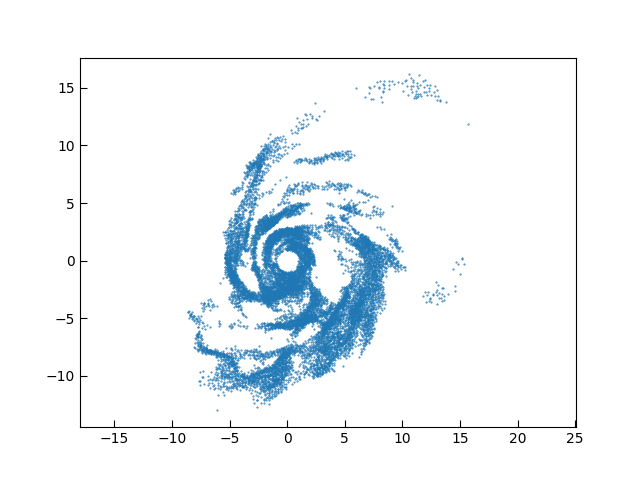

In [19]:
%matplotlib widget

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficar puntos
plt.scatter(Xs, Ys, s=0.2)

# Ajustar los ejes a la misma escala
plt.axis('equal')

plt.show()


In [20]:
b=0.4 #valor david b=0.4
min_prop  = np.min(prop_final[ np.absolute(Ys) < b])

Xs_band   = Xs[ (np.absolute(Ys) < b) ]
Ys_band   = Ys[ (np.absolute(Ys) < b) ]
prop_band = prop_final[ np.absolute(Ys) < b]-min_prop

In [21]:
prop_band

5        6.195337e-06
29       1.400926e-05
39       8.255046e-06
40       1.263464e-05
45       7.252661e-06
48       8.403923e-06
51       6.609079e-06
54       6.518937e-06
59       8.229946e-06
110      6.502492e-06
124      1.180706e-05
137      1.271966e-05
142      6.377088e-06
147      9.674493e-06
150      6.902383e-06
186      6.071764e-06
206      1.221869e-05
227      9.405880e-06
230      8.129886e-06
231      7.216180e-06
234      1.359901e-05
236      1.216848e-05
238      9.957375e-06
240      1.578333e-05
250      9.527748e-06
252      1.271339e-05
253      1.051583e-05
257      8.567697e-06
268      1.003057e-05
275      1.592688e-05
             ...     
11083    3.610450e-05
11087    3.366678e-05
11105    1.392542e-05
11174    3.110072e-05
11175    3.518748e-05
11210    2.350030e-05
11234    2.382654e-05
11296    2.446694e-05
11329    1.311724e-05
11360    2.347586e-05
11378    3.175049e-05
11420    2.676647e-05
11475    1.591299e-05
11526    2.246862e-05
11537    2

In [22]:
Xs_band

5        -0.908405
29       -0.962604
39       -0.927796
40       -1.107864
45       -1.096620
48       -1.172325
51       -1.198382
54       -1.227900
59       -1.227020
110      -1.101804
124      -0.946580
137      -0.955486
142      -0.973419
147       0.927650
150       0.983363
186      -1.341784
206       0.998210
227       1.024550
230       1.024255
231      -1.094540
234       1.081567
236      -0.945113
238       1.004448
240       1.191111
250      -1.007546
252       1.082638
253       1.002785
257       1.169887
268       1.155005
275       1.158654
           ...    
11083     9.153056
11087     8.852243
11105     8.583631
11174     8.865950
11175     9.158215
11210     8.994233
11234     8.985287
11296     9.226980
11329     8.995918
11360     8.894381
11378     9.396329
11420     9.055614
11475     9.609409
11526     8.991686
11537     9.548890
11581     9.286817
11607     9.553910
11658     9.477979
11671     9.175287
11697     9.122629
11718     9.547542
11829     9.

In [23]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


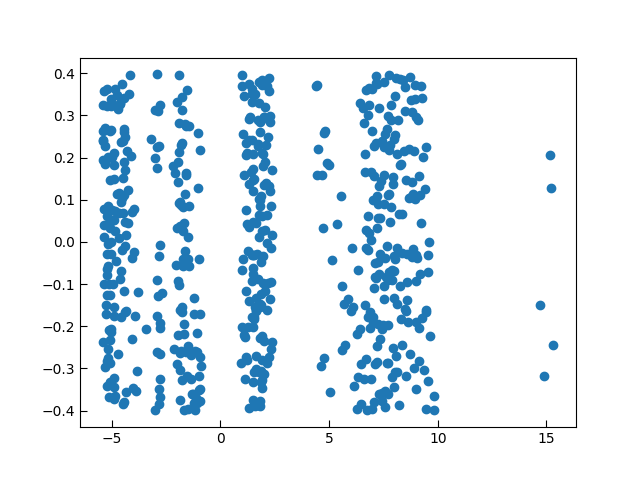

In [24]:
%matplotlib widget
plt.scatter(Xs_band, Ys_band,alpha=1);


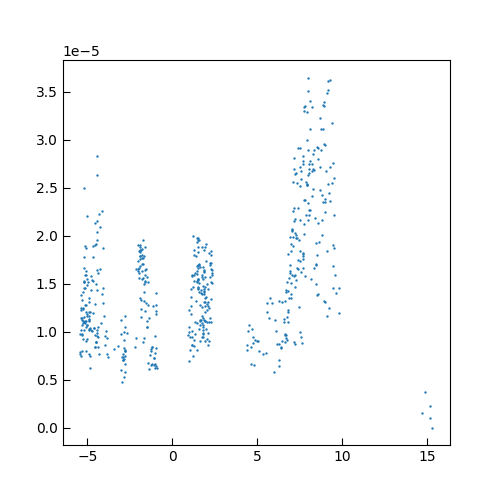

In [25]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Xs_band, prop_band,s=0.5,alpha=1)

#ax.set_xlim()

## Arm Tracing Points Data

In [26]:
samplig_freq=1
df_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

df_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

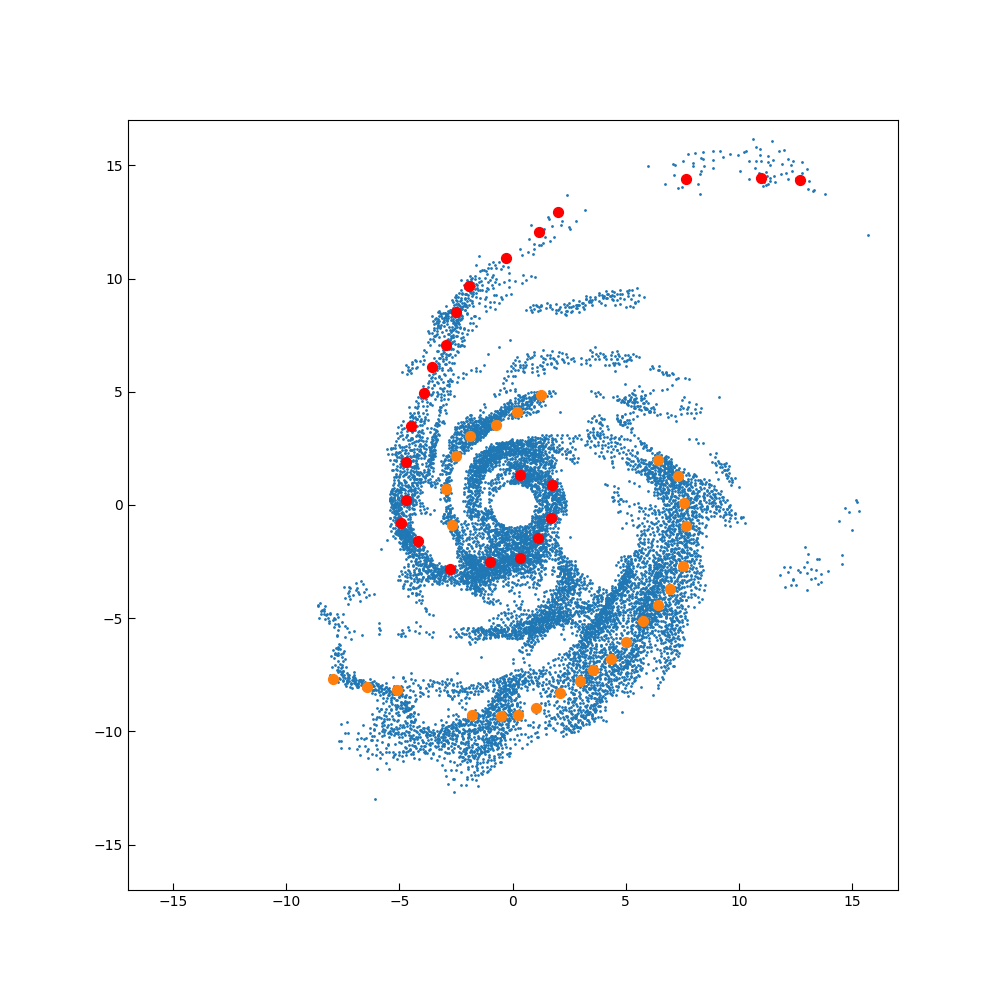

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 50, color = 'red')
ax.scatter(df_arm2.x, df_arm2.y, s = 50, color = 'C1')
R = 17
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_aspect('equal')

## Rotations

In [28]:
def rotate(x, y, radians):
    x_rot = x * np.cos(radians) + y * np.sin(radians)
    y_rot = -x * np.sin(radians) + y * np.cos(radians)
    return {'x_rot':x_rot,'y_rot':y_rot}

In [29]:
def get_rotations(df_data, x_rot, y_rot):
    Xs = df_data.x
    Ys = df_data.y
    
    if x_rot > 0 and y_rot > 0 :
        a = np.arctan(y_rot/x_rot)
        return rotate(Xs, Ys, a), a

    elif x_rot < 0 and y_rot > 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a    
    
    elif x_rot < 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a   
    
    elif x_rot > 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + 2*np.pi
        return rotate(Xs, Ys, a), a 

In [30]:
def get_rotated_arm_profile(prop, rotation_coords, b):
    x_rot = rotation_coords['x_rot']
    y_rot = rotation_coords['y_rot']
    
    min_prop  = np.min(prop[ np.absolute(y_rot)<b] )
    x_band = x_rot[ (np.absolute(y_rot)<b) ]
    y_band = prop[ np.absolute(y_rot)<b] - min_prop
    
    return {'x_band':x_band,'y_band':y_band}

In [31]:
b = 0.3

In [32]:
df_arm1['rotation_info'] = df_arm1.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm1['rotation_coords'] = df_arm1.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm1['alpha'] = df_arm1.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm1['All_tracingPoints_rot'] = df_arm1.apply(lambda row: rotate(df_arm1.x, df_arm1.y, row.alpha), axis = 1)
df_arm1['This_tracingPoint_rot'] = df_arm1.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm1['rotated_arm_profile'] = df_arm1.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)


df_arm2['rotation_info'] = df_arm2.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm2['rotation_coords'] = df_arm2.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm2['alpha'] = df_arm2.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm2['All_tracingPoints_rot'] = df_arm2.apply(lambda row: rotate(df_arm2.x, df_arm2.y, row.alpha), axis = 1)
df_arm2['This_tracingPoint_rot'] = df_arm2.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm2['rotated_arm_profile'] = df_arm2.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)



df_arms['rotation_info'] = df_arms.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arms['rotation_coords'] = df_arms.apply(lambda row: row.rotation_info[0], axis = 1)
df_arms['alpha'] = df_arms.apply(lambda row: row.rotation_info[1], axis = 1)
df_arms['All_tracingPoints_rot'] = df_arms.apply(lambda row: rotate(df_arms.x, df_arms.y, row.alpha), axis = 1)
df_arms['This_tracingPoint_rot'] = df_arms.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arms['rotated_arm_profile'] = df_arms.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)

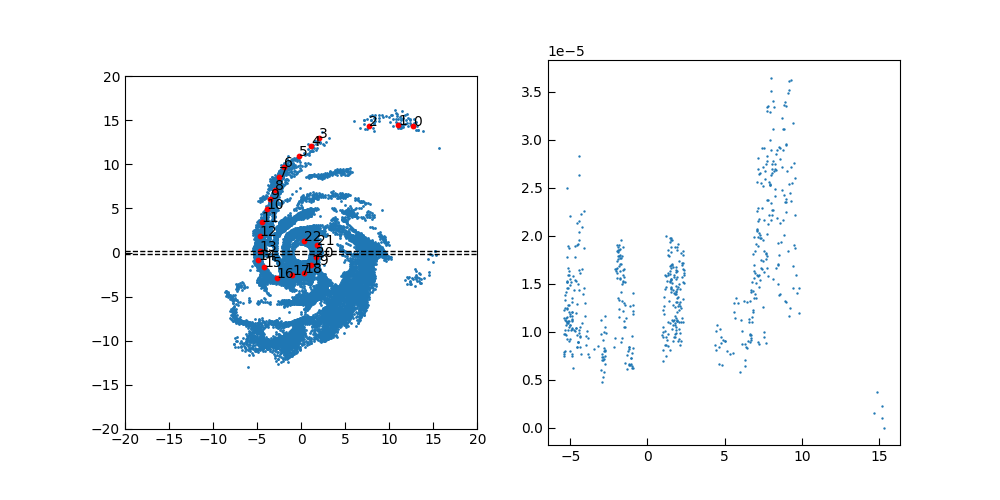

In [33]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

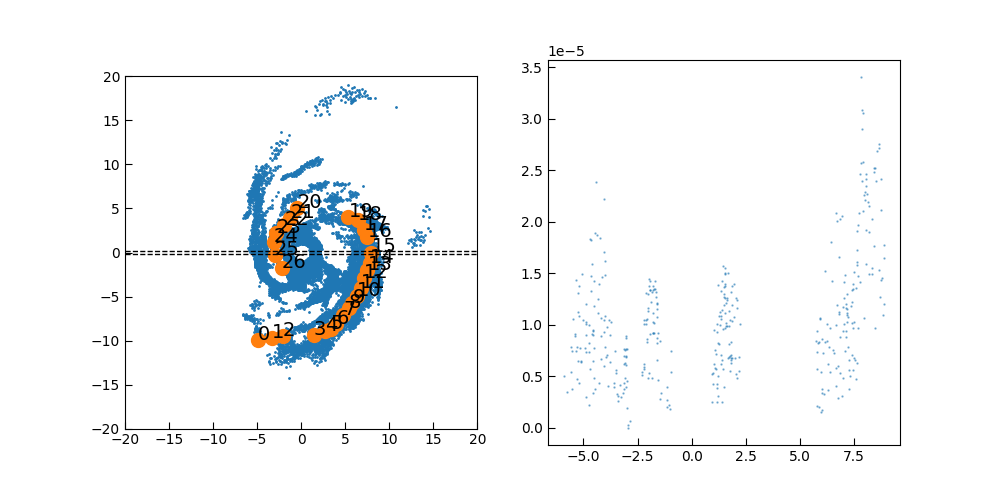

In [34]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
n = 15
ax.scatter(df_arm2.iloc[n].rotation_coords['x_rot'], df_arm2.iloc[n].rotation_coords['y_rot'], s = 1)
ax.scatter(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'], df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], s = 100)

for x, y, id in zip(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'],df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], df_arm2.id):
    ax.text(x, y, str(int(id)), fontsize = 14)

ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(df_arm2.iloc[n].rotated_arm_profile['x_band'], df_arm2.iloc[n].rotated_arm_profile['y_band'], s = 0.5, alpha = 0.5)

ax.set_aspect('equal')

# Fitting Procedure

In [35]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})


In [36]:
#df_params = pd.DataFrame(columns = ['amplitude','stderr_amplitude','center','stderr_center',
                                   # 'sigma','stderr_sigma','gamma','stderr_gamma',
                                   # 'x','y','delta','x_tracing','y_tracing','id_tracing'])

In [37]:
arm = df_arm2.copy(deep=True)

In [38]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,-7.915584,-7.670455,2,0,"({'x_rot': [0.9298452455868048, 0.997775879034...","{'x_rot': [0.9298452455868048, 0.9977758790343...",3.911265,"{'x_rot': [11.02235680669643, 10.1935394780574...","{'x_rot': 11.02235680669643, 'y_rot': -8.88178...","{'x_band': [0.9977758790343665, 1.012152199901..."
1,-6.409091,-8.034091,2,1,"({'x_rot': [0.9646997401459014, 1.014046605595...","{'x_rot': [0.9646997401459014, 1.0140466055955...",4.039029,"{'x_rot': [10.932515353300687, 10.277308160045...","{'x_rot': 10.277308160045067, 'y_rot': 3.55271...","{'x_band': [0.9646997401459014, 1.014046605595..."
2,-5.110390,-8.189935,2,2,"({'x_rot': [0.9826837995777098, 1.014531307473...","{'x_rot': [0.9826837995777098, 1.0145313074731...",4.154521,"{'x_rot': [10.697846359936179, 10.208844048852...","{'x_rot': 9.653554699582477, 'y_rot': -3.55271...","{'x_band': [0.9826837995777098, 1.014531307473..."
3,-1.785714,-9.280844,2,3,"({'x_rot': [0.9526559161601696, 0.927111292248...","{'x_rot': [0.9526559161601696, 0.9271112922488...",4.522303,"{'x_rot': [9.027888724155922, 9.10033395903424...","{'x_rot': 9.451076327872435, 'y_rot': 1.554312...","{'x_band': [0.9526559161601696, 1.059850735746..."
4,-0.487013,-9.332792,2,4,"({'x_rot': [0.907755708792362, 0.8611568615333...","{'x_rot': [0.907755708792362, 0.86115686153335...",4.660253,"{'x_rot': [8.072529858075539, 8.35716561136025...","{'x_rot': 9.345490465638829, 'y_rot': -8.32667...","{'x_band': [1.05606636909612, 0.96515248308227..."
5,0.240260,-9.280844,2,5,"({'x_rot': [0.8746585834859029, 0.816519425822...","{'x_rot': [0.8746585834859029, 0.8165194258227...",4.738271,"{'x_rot': [7.463037899243215, 7.86553906970460...","{'x_rot': 9.283953521418358, 'y_rot': 2.498001...","{'x_band': [1.045022890950064, 0.9593641422102..."
6,1.019481,-8.969156,2,6,"({'x_rot': [0.8313271974050929, 0.760697589909...","{'x_rot': [0.8313271974050929, 0.7606975899091...",4.825568,"{'x_rot': [6.727409571284885, 7.25885966954965...","{'x_rot': 9.026909608850373, 'y_rot': 2.220446...","{'x_band': [1.0251335684613527, 0.945971195638..."
7,2.110390,-8.293831,2,7,"({'x_rot': [0.7513538913213068, 0.662373044509...","{'x_rot': [0.7513538913213068, 0.6623730445095...",4.961554,"{'x_rot': [5.481636165604453, 6.20553679627911...","{'x_rot': 8.55811776997231, 'y_rot': -1.332267...","{'x_band': [1.0200419341216864, 1.115375100533..."
8,2.993506,-7.774351,2,8,"({'x_rot': [0.6703765718490534, 0.566746090007...","{'x_rot': [0.6703765718490534, 0.5667460900073...",5.079941,"{'x_rot': [4.313824641188823, 5.19450446047044...","{'x_rot': 8.330762818957483, 'y_rot': 3.108624...","{'x_band': [0.9921144292344245, 1.092254577546..."
9,3.564935,-7.306818,2,9,"({'x_rot': [0.6053140420666216, 0.491900953410...","{'x_rot': [0.6053140420666216, 0.4919009534107...",5.166303,"{'x_rot': [3.4228494742340727, 4.4102403756329...","{'x_rot': 8.13008941890262, 'y_rot': 5.7731597...","{'x_band': [1.0179723551212365, 0.971344247192..."


(-4.0, 4.0)

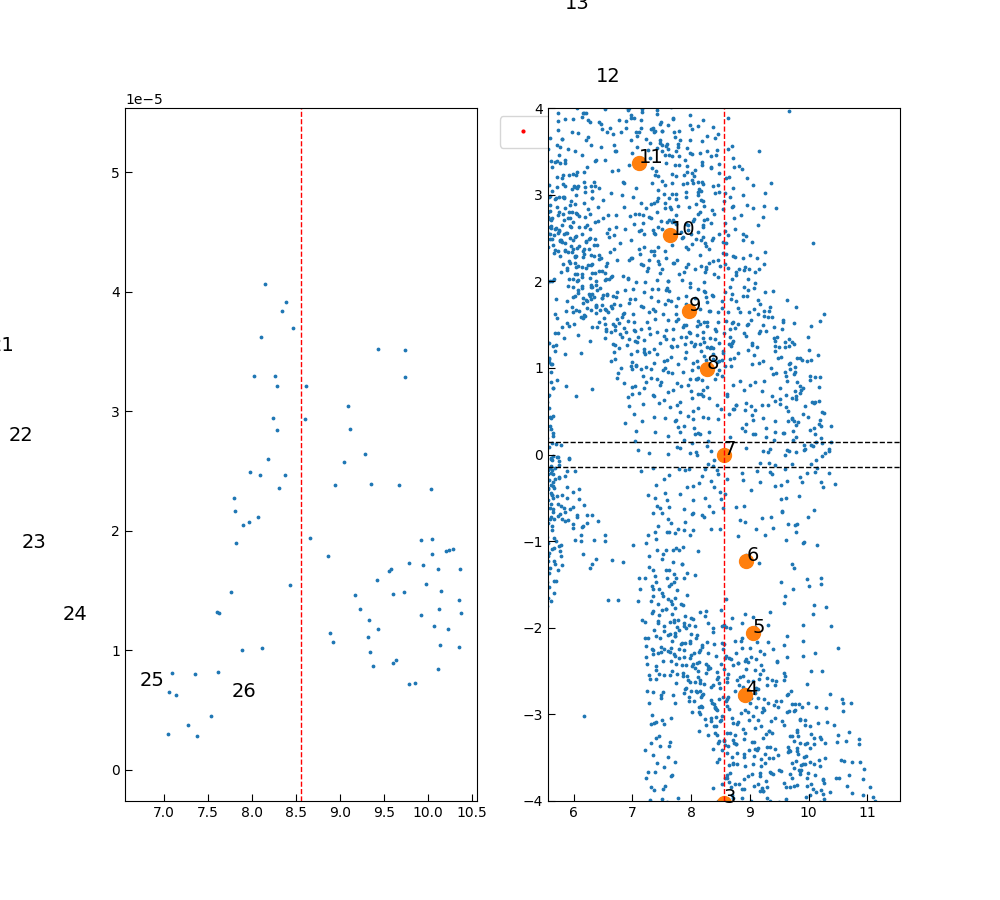

In [59]:
%matplotlib widget

n= 7 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,9), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-4,4)

## %run Routines_and_data/gauss_asym.py

In [60]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [61]:
dict_lims

{'limits': array([[6.99102100e+00, 2.26914757e-06],
        [6.99102100e+00, 3.69292644e-06],
        [7.05915003e+00, 5.61921550e-06],
        [7.12727906e+00, 6.87549097e-06],
        [7.20676293e+00, 8.46677324e-06],
        [7.29760164e+00, 1.00580555e-05],
        [7.35437583e+00, 1.21518480e-05],
        [7.38844035e+00, 1.47481506e-05],
        [7.45656938e+00, 1.60044261e-05],
        [7.52469842e+00, 1.73444532e-05],
        [7.57011777e+00, 1.91869906e-05],
        [7.64960164e+00, 2.14482865e-05],
        [7.79721454e+00, 2.38770857e-05],
        [7.84263390e+00, 2.63058850e-05],
        [7.88805325e+00, 2.95722012e-05],
        [7.94482745e+00, 3.12472352e-05],
        [8.01295648e+00, 3.40110412e-05],
        [8.21734358e+00, 3.69423506e-05],
        [8.35360164e+00, 3.97061567e-05],
        [8.56934358e+00, 4.07111770e-05],
        [8.68289196e+00, 4.02086669e-05],
        [8.89863390e+00, 3.87011363e-05],
        [9.05760164e+00, 3.67748472e-05],
        [9.33011777e+00,

In [62]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


In [63]:
n

7

(1.038700206858786e-18, 2.8928134911295665e-05)

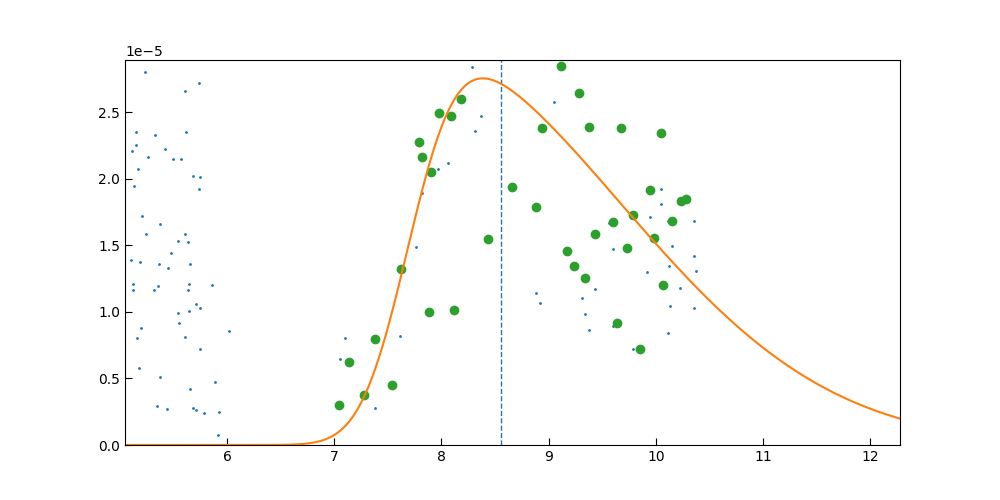

In [64]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [65]:
fractured = False

In [66]:
model['x_max']

0      7.049162
1      7.140514
2      7.278781
3      7.378892
4      7.540289
5      7.622462
6      7.790545
7      7.815883
8      7.881523
9      7.902132
10     7.977413
11     8.019852
12     8.090449
13     8.119142
14     8.183668
15     8.234830
16     8.286924
17     8.335714
18     8.388391
19     8.436686
20     8.463293
21     8.615237
22     8.660234
23     8.886263
24     8.939052
25     9.086955
26     9.114206
27     9.172182
28     9.231858
29     9.283153
30     9.341894
31     9.378760
32     9.430035
33     9.598570
34     9.634206
35     9.674842
36     9.727022
37     9.783147
38     9.849178
39     9.944175
40     9.981053
41    10.047537
42    10.067988
43    10.147555
44    10.232386
45    10.277096
dtype: float64

In [67]:
list(model['x_max'])

[7.049161552851497,
 7.140513619787687,
 7.278780859643688,
 7.378891791564721,
 7.540288966949517,
 7.622461647035587,
 7.790544817719198,
 7.81588295413147,
 7.881523221308356,
 7.902131928930428,
 7.97741306413716,
 8.01985243317624,
 8.090448554174673,
 8.119141961756045,
 8.183667568468042,
 8.234829578788439,
 8.286924325226463,
 8.335714229997668,
 8.388391265012507,
 8.436685744367905,
 8.463293109607259,
 8.61523719758329,
 8.660233701249888,
 8.886263188816164,
 8.939052169221306,
 9.086955196276167,
 9.114205699582895,
 9.172182320197281,
 9.231857617969597,
 9.283152801551713,
 9.341893955557673,
 9.378760112979354,
 9.430035288967678,
 9.598569767076043,
 9.63420611751286,
 9.674841813640862,
 9.727021860586259,
 9.783147426692695,
 9.849177927730814,
 9.944174616839577,
 9.981053384011371,
 10.047536604050283,
 10.067987821344179,
 10.147554746628792,
 10.232385889398163,
 10.277095624501184]

In [68]:
df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [69]:
df_params.tail()

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000062,7.779178,0.05,False,3.256871,7.0,1.428761,0.000006,0.112887,1.739026,0.278157,"[7.140513619787687, 7.278780859643688, 7.37889...",2.11039,"[8.070066093515586e-06, 3.741778185339923e-06,...",-8.293831
1,0.000074,7.694545,0.05,False,5.470631,7.0,1.963680,0.000007,0.092051,2.570449,0.318829,"[7.049161552851497, 7.140513619787687, 7.27878...",2.11039,"[3.000142740849324e-06, 6.262135655477005e-06,...",-8.293831


In [70]:
df_params

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000062,7.779178,0.05,False,3.256871,7.0,1.428761,0.000006,0.112887,1.739026,0.278157,"[7.140513619787687, 7.278780859643688, 7.37889...",2.11039,"[8.070066093515586e-06, 3.741778185339923e-06,...",-8.293831
1,0.000074,7.694545,0.05,False,5.470631,7.0,1.963680,0.000007,0.092051,2.570449,0.318829,"[7.049161552851497, 7.140513619787687, 7.27878...",2.11039,"[3.000142740849324e-06, 6.262135655477005e-06,...",-8.293831


In [71]:
df_params['y']

0    [8.070066093515586e-06, 3.741778185339923e-06,...
1    [3.000142740849324e-06, 6.262135655477005e-06,...
Name: y, dtype: object

In [72]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 7.41459e-05
center                                                        7.69454
delta                                                            0.05
fractured                                                       False
gamma                                                         5.47063
id_tracing                                                          7
sigma                                                         1.96368
stderr_amplitude                                          7.01879e-06
stderr_center                                               0.0920508
stderr_gamma                                                  2.57045
stderr_sigma                                                 0.318829
x                   [7.049161552851497, 7.140513619787687, 7.27878...
x_tracing                                                     2.11039
y                   [3.000142740849324e-06, 6.262135655477005e-06,...
y_tracing           

In [73]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.001):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



In [74]:
arm.iloc[n].id

7

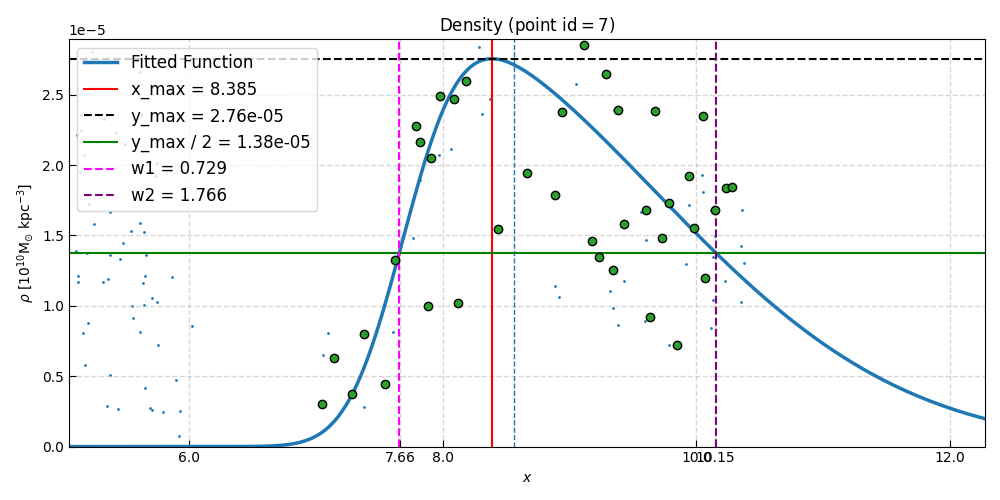

In [75]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_halo{id_halo}_.png',dpi=200)

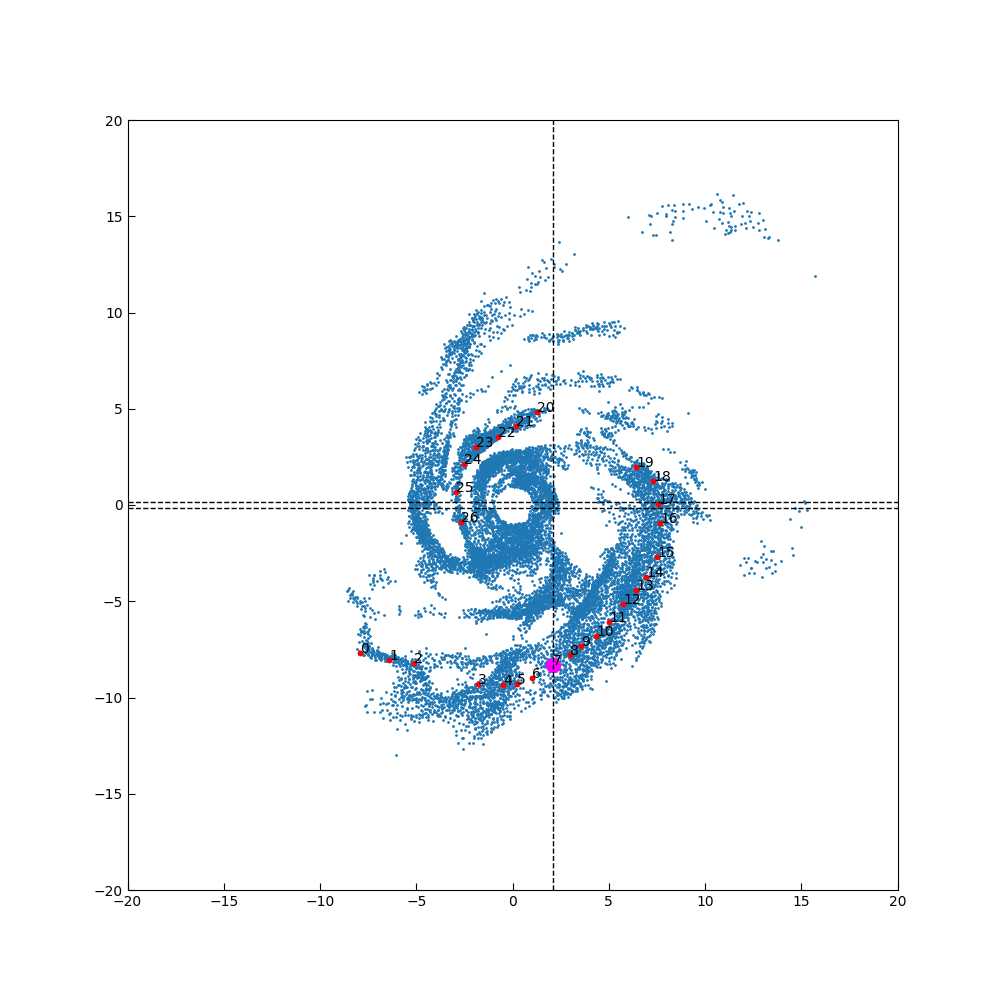

In [76]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm2.x, df_arm2.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm2.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [77]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_adicionales_HALO{id_halo}_.csv', index = False)

In [78]:
df_params.to_csv('df_params_rho_arm2_adicionales_dani.csv')

## arm 1

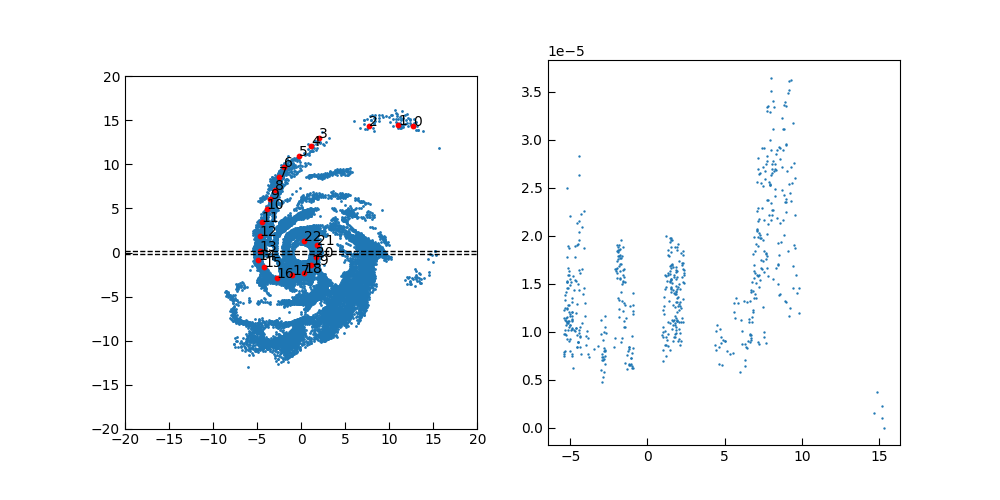

In [79]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

In [80]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})

arm = df_arm1.copy(deep=True)

In [81]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,12.707792,14.355519,1,0,"({'x_rot': [-0.952586684772841, -1.00949898468...","{'x_rot': [-0.952586684772841, -1.009498984680...",0.846207,"{'x_rot': [19.17208706301948, 18.1136053217362...","{'x_rot': 19.17208706301948, 'y_rot': -1.77635...","{'x_band': [-0.952586684772841, -1.00949898468..."
1,10.993506,14.459416,1,1,"({'x_rot': [-0.9693728619868038, -1.0152350559...","{'x_rot': [-0.9693728619868038, -1.01523505591...",0.920735,"{'x_rot': [19.118866893315158, 18.164027198438...","{'x_rot': 18.164027198438397, 'y_rot': 1.77635...","{'x_band': [-0.9693728619868038, -1.0152350559..."
2,7.668831,14.407468,1,2,"({'x_rot': [-0.987180225629339, -1.00839702645...","{'x_rot': [-0.987180225629339, -1.008397026454...",1.081658,"{'x_rot': [18.643115133616003, 17.929344756523...","{'x_rot': 16.32133855402622, 'y_rot': 0.0}","{'x_band': [-0.987180225629339, -1.00839702645..."
3,2.006494,12.952922,1,3,"({'x_rot': [-0.9425372413147356, -0.9113733635...","{'x_rot': [-0.9425372413147356, -0.91137336352...",1.417111,"{'x_rot': [16.13164018168546, 15.9718874191430...","{'x_rot': 13.107410367739387, 'y_rot': -1.1102...","{'x_band': [-0.9425372413147356, -1.0608117701..."
4,1.175325,12.069805,1,4,"({'x_rot': [-0.9243236923972048, -0.8845049183...","{'x_rot': [-0.9243236923972048, -0.88450491835...",1.473725,"{'x_rot': [15.519562370116002, 15.456822768777...","{'x_rot': 12.126895131606178, 'y_rot': 1.11022...","{'x_band': [-1.0595138540081392, -0.9658222925..."
5,-0.279221,10.926948,1,5,"({'x_rot': [-0.874811805124579, -0.81672135862...","{'x_rot': [-0.874811805124579, -0.816721358627...",1.596344,"{'x_rot': [14.026213412902207, 14.173867162457...","{'x_rot': 10.930514991230744, 'y_rot': 1.27675...","{'x_band': [-1.0450837944151616, -0.9594014081..."
6,-1.941558,9.680195,1,6,"({'x_rot': [-0.7831913011060156, -0.7009475595...","{'x_rot': [-0.7831913011060156, -0.70094755955...",1.768740,"{'x_rot': [11.576165769162134, 12.015153643184...","{'x_rot': 9.872984384091133, 'y_rot': 2.220446...","{'x_band': [-0.9260715773668076, -1.1137356536..."
7,-2.512987,8.537338,1,7,"({'x_rot': [-0.7270565770638069, -0.6333404699...","{'x_rot': [-0.7270565770638069, -0.63334046991...",1.857064,"{'x_rot': [10.182967749098019, 10.766704963184...","{'x_rot': 8.899507744151386, 'y_rot': 4.440892...","{'x_band': [-1.0128112868177148, -1.1097981022..."
8,-2.928571,7.082792,1,8,"({'x_rot': [-0.6523925896673177, -0.5459029858...","{'x_rot': [-0.6523925896673177, -0.54590298581...",1.962867,"{'x_rot': [8.410545745949815, 9.16159079699172...","{'x_rot': 7.664364035652725, 'y_rot': 4.440892...","{'x_band': [-1.0855402207062137, -0.9764650801..."
9,-3.551948,6.095779,1,9,"({'x_rot': [-0.5462195589267671, -0.4251260581...","{'x_rot': [-0.5462195589267671, -0.42512605816...",2.098390,"{'x_rot': [6.005652566973281, 6.95848852004662...","{'x_rot': 7.0551299968336, 'y_rot': 2.66453525...","{'x_band': [-1.0011710803621217, -0.9681928246..."


(-2.5, 2.5)

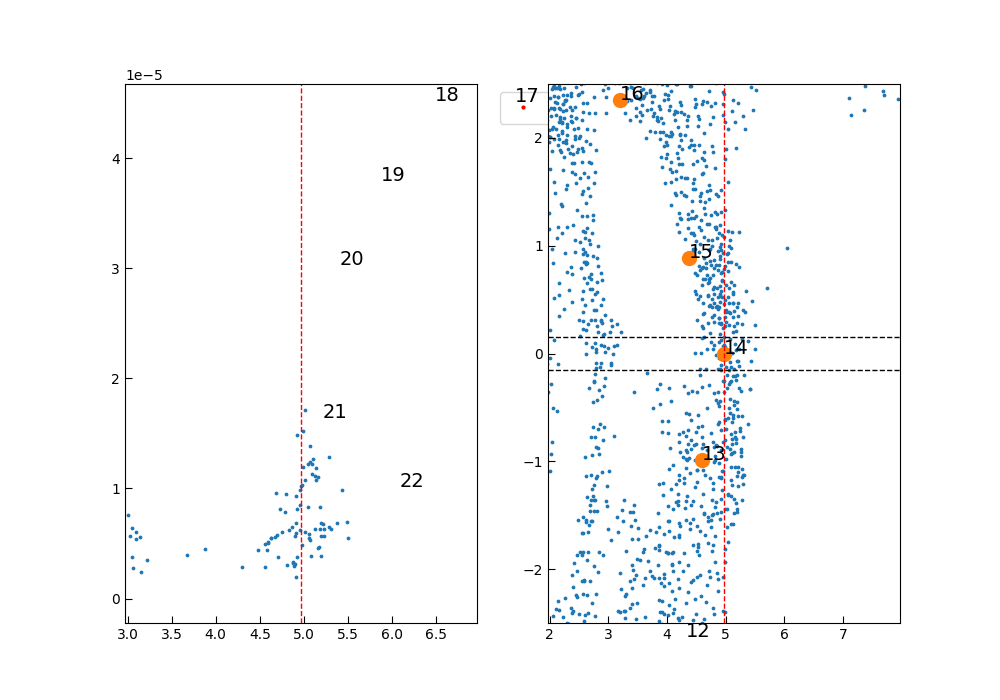

In [82]:
n= 14 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

In [84]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [85]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(3.646652144509628e-20, 1.3586121677327436e-05)

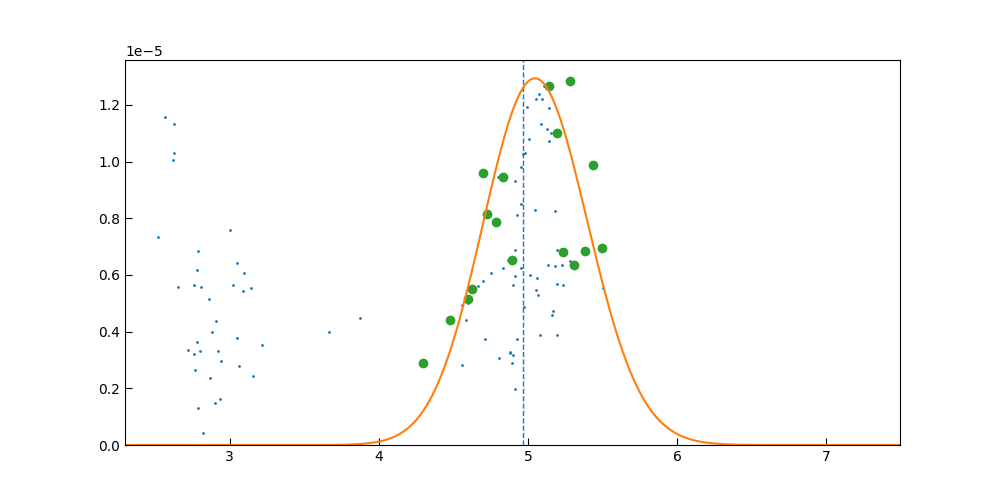

In [86]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [87]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

/home/daniel/Documentos/UdeA/SpiralStructure_IllustrisTNG50/ROUTINES/gauss_asym.py:137: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, pd.DataFrame.from_records([dict_values])], ignore_index=True)


In [88]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 1.13657e-05
center                                                        4.87937
delta                                                            0.05
fractured                                                       False
gamma                                                        0.686374
id_tracing                                                         14
sigma                                                        0.393644
stderr_amplitude                                          1.36373e-06
stderr_center                                                0.889328
stderr_gamma                                                  4.44307
stderr_sigma                                                  0.49581
x                   [4.298750736065823, 4.480197704769558, 4.59564...
x_tracing                                                     -4.9026
y                   [2.877623224295711e-06, 4.410360268359912e-06,...
y_tracing           

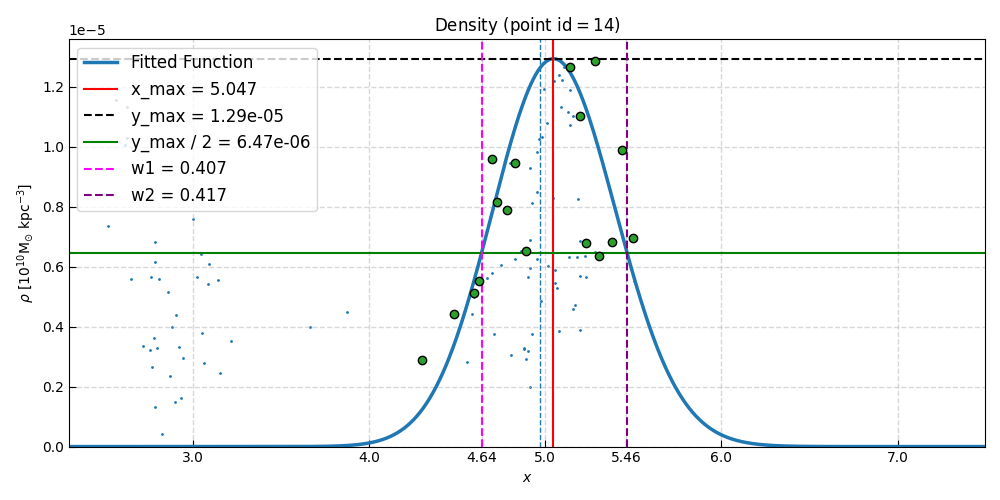

In [89]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_HALO{id_halo}_.png',dpi=200)

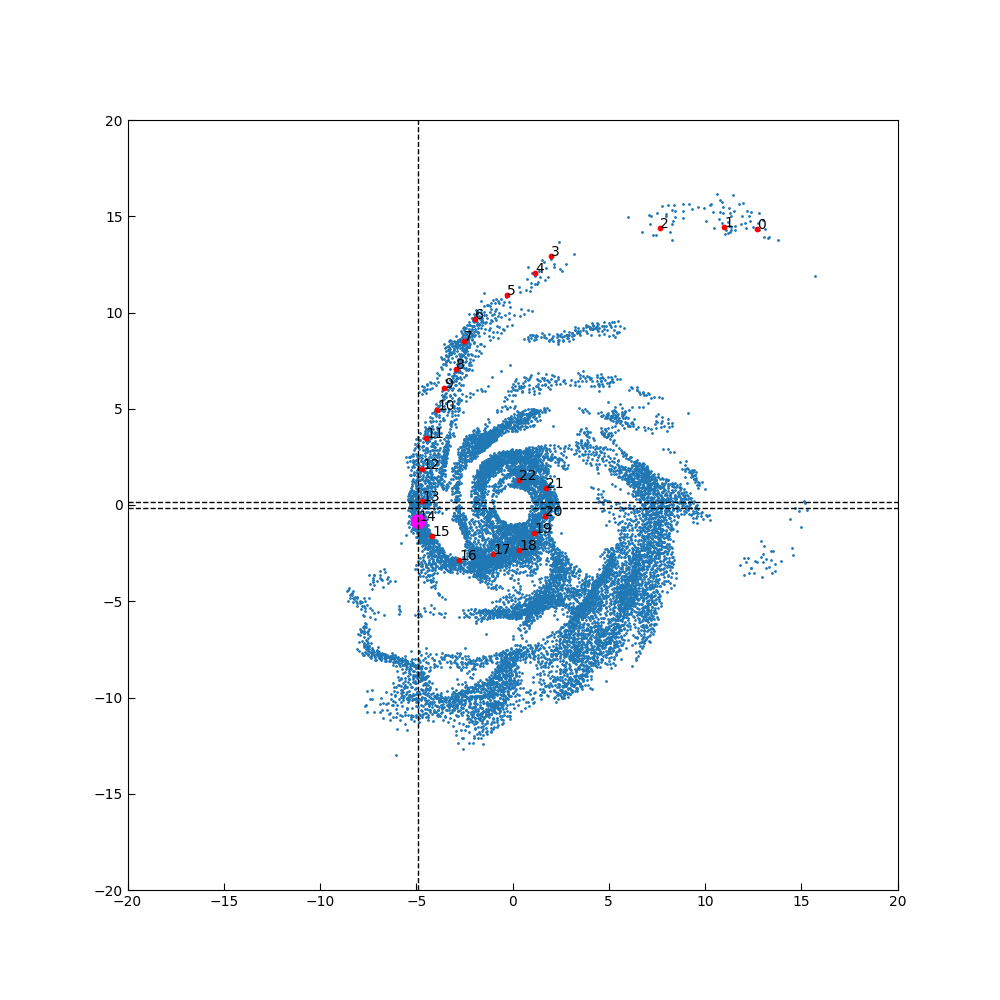

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [91]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_adicionales_HALO{id_halo}_.csv', index = False)


AttributeError: 'Series' object has no attribute 'This_tracingPoint_rot'

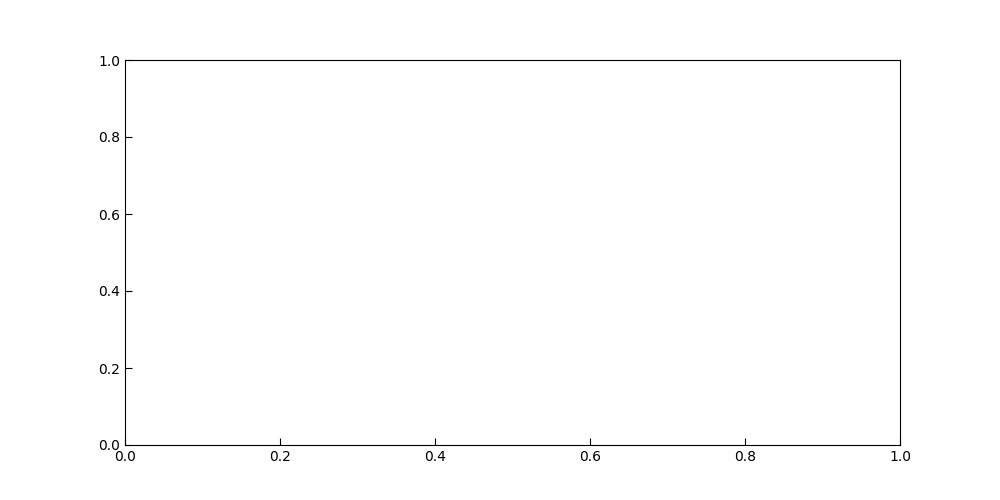

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Definir la función gaussiana
def gaussian(x, amplitude, center, sigma, offset):
    return amplitude * np.exp(-((x - center) ** 2) / (2 * sigma ** 2)) + offset

# Cargar los datos del perfil de rotación de los brazos espirales
samplig_freq = 1
df_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

df_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

# DataFrame para guardar los parámetros del ajuste
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})

arm = df_arm1.copy(deep=True)  # Trabajamos con el brazo 1 como ejemplo

# Bucle para iterar sobre los puntos en el DataFrame
for n in range(len(arm)):
    fig, ax = plt.subplots(figsize=(10,5))

    # Obtener los datos para el ajuste
    x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
    y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
    x_band = arm.iloc[n].rotated_arm_profile['x_band']
    y_band = arm.iloc[n].rotated_arm_profile['y_band']
    
    # Trazar los puntos originales
    ax.scatter(x_band, y_band, s=3, alpha=1)
    ax.axvline(x=x_tracing, lw=1, ls='--', color='red')
    ax.set_xlim(x_tracing-2, x_tracing+2)
    
    # Ajuste gaussiano para el perfil de densidad
    try:
        popt, pcov = curve_fit(gaussian, x_band, y_band, p0=[np.max(y_band), x_tracing, 1.0, np.min(y_band)])
        # Calcular el error estándar de los parámetros ajustados
        perr = np.sqrt(np.diag(pcov))
        
        # Trazar la gaussiana ajustada
        x_vals = np.linspace(np.min(x_band), np.max(x_band), 100)
        y_vals = gaussian(x_vals, *popt)
        ax.plot(x_vals, y_vals, color='C1', label=f'Fit: Center={popt[1]:.2f}, Sigma={popt[2]:.2f}')
        
        ax.legend()
        
        # Guardar los parámetros ajustados en el DataFrame
        df_params = df_params.append({
            'amplitude': popt[0],
            'stderr_amplitude': perr[0],
            'center': popt[1],
            'stderr_center': perr[1],
            'sigma': popt[2],
            'stderr_sigma': perr[2],
            'gamma': popt[3],
            'stderr_gamma': perr[3],
            'x': x_band,
            'y': y_band,
            'delta': 0.0,  # Aquí puedes agregar algún cálculo adicional si es necesario
            'x_tracing': x_tracing,
            'y_tracing': y_tracing,
            'id_tracing': arm.iloc[n].id
        }, ignore_index=True)
    except RuntimeError:
        print(f"Ajuste fallido para n={n}")

# Guardar el DataFrame final con los parámetros ajustados
df_params.to_csv('ajustes_gaussianos.csv', index=False)

print("Proceso completado y parámetros guardados.")

